The goal of this notebook is to compile a list of chord n-grams by frequency from the entire database.
My main goal is to do this counting chords as harmonically equivalent, but I will also do it more literally.

In [2]:
# importing basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
import copy
from collections import Counter, deque

# read in the data set
df = pd.read_csv('../data/chordonomicon.csv', low_memory=False)

In [3]:
# Read the mapping CSV file
chord_relations = pd.read_csv('../data/chords_mapping.csv')

# Create a dictionary with keys the "chords" and values the "degrees"
chord_degrees = dict(zip(chord_relations['Chords'], chord_relations['Degrees']))
for key, value in chord_degrees.items():
    chord_degrees[key] = ast.literal_eval(value)
    
# full list of chords from the chords_mapping csv
known_chords = list(chord_degrees.keys())

In [4]:
# drop all columns except for chords and genres
chord_data = df[['chords','genres']]

# drop anything that lacks chord or genre data
chord_data = chord_data.dropna()

In [5]:
# replacing spaces with commas
def replace_space_with_comma(my_string):
    return my_string.replace(" ",",")

# Remove section markers
def remove_section_markers(my_string):
    result = []
    i = 0
    n = len(my_string)
    while i < n:
        if my_string[i] == '<':
            # Skip until after the following ", "
            j = my_string.find('>', i)
            if j == -1:
                break  # no closing '>', stop
            i = j + 2  # skip '>,' and the space
        else:
            result.append(my_string[i])
            i += 1
    assert('<' not in result)
    assert('>' not in result)
    return ''.join(result)

# Remove inversions
def remove_inversions(my_string):
    result = []
    i = 0
    n = len(my_string)
    while i < n:
        if my_string[i] == '/':
            # Skip until after the following ", "
            j = my_string.find(',', i)
            if j == -1:
                break  # no closing comma, stop
            i = j  # skip comma
        else:
            result.append(my_string[i])
            i += 1
    return ''.join(result)

def clean_up_chord_string(my_string):
    return remove_inversions(
        remove_section_markers(
            replace_space_with_comma(my_string)))

# replacing spaces with commons in all chords in all rows of the data
chord_data.loc[:,'chords'] = chord_data['chords'].apply(clean_up_chord_string)

In [6]:
chord_data.sample(5)

,chords,genres
108303,"Db,Bb,Fmin,Gb,Db,Bb,Fmin,Gb,Db,Bb,Fmin,Gb,Db,B...","grunge""underground grunge"
242305,"A,D,A,E,A,G,D,F,A,G,D,E,D,A,E,G,D,A,E,D,A,D,A,...","ccm""christian alternative rock""christian music"
243730,"G,Bmin,G,Bmin,Amin,D,Amin,C,D,G,D,C,D,G,Bmin,G...","jangle pop""new romantic""new wave""welsh rock"
412503,"G,F,C,G,F,C,G,F,C,G,F,C,G,F,C,G,F,C,G,F,C,G,F,...",argentine rock
430288,"C,Dmin,Emin,Dsmin,Dmin,G7,Dmin,G7,C,Dmin,Emin,...","bolero""bolero mexicano""guitarra mexicana""mexic..."


In [7]:
# simplify genre data
major_genres = ['pop','rock','country','alternative','punk','metal','rap','soul','jazz','reggae','electronic']
def simplify_genre(genre_string):
    for g in major_genres:
        if g in genre_string:
            return g
    return 'other'

chord_data.loc[:,'genres'] = chord_data['genres'].apply(simplify_genre)

In [8]:
chord_data.sample(5)

,chords,genres
15836,"D,G,C,G,D7,G,D7,G,D7,G,C,G,D7,G,C,G,D7,G,D,G,C...",pop
418482,"B,E,Fs7,B,E,Fs7,B,E,Fs7,B,E,Fs7,B,E,Fs7,E,Fs,C...",pop
473217,"E,A,E,A,E,A,E,A,Cmaj7,B,A,Cmaj7,B,A,Cmaj7,B,A,...",rock
171469,"Cmin,Ab,G7,Cmin,G7,Cmin,Ab,G7,Cmin,G7,Fmin,Cmi...",other
85881,"Eno3d,E,Eno3d,E,Eno3d,E,Eno3d,Ano3d,E,Eno3d,Es...",soul


In [9]:
genre_counter = Counter(chord_data.genres)
genre_counter

Counter({'pop': 131247,
         'other': 106961,
         'rock': 81276,
         'country': 15884,
         'punk': 10060,
         'alternative': 4358,
         'rap': 4013,
         'metal': 3007,
         'soul': 2909,
         'reggae': 2156,
         'jazz': 1857,
         'electronic': 545})

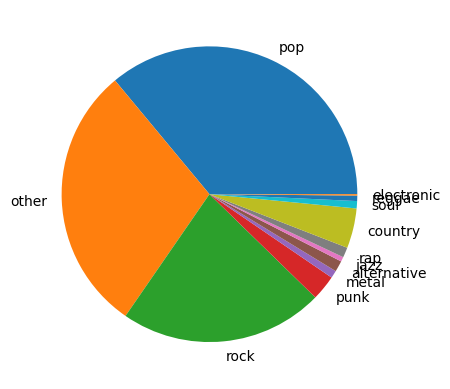

In [10]:
plt.pie(x = list(genre_counter.values()), 
        labels = list(genre_counter.keys()))
plt.show()

In [11]:
# method to transpose a chord in vector format
def transpose_chord_up(chord_vector, num_semitones):
    d = deque(chord_vector)
    d.rotate(num_semitones)
    return(list(d))
    
# method to return true if chord_1 and chord_2 are just tranposed versions of each other
def is_harmonic_equivalent(chord_1, chord_2):
    # if they have different numbers of notes, then we don't have to check if 
    # any of the transpositions are equal
    if sum(chord_1) != sum(chord_2):
        return False

    # if they have the same number of notes, just rotate through the 12 possible transpositions to check
    for i in range(12):
        if np.array_equal(chord_1, transpose_chord_up(chord_2, i)):
            return True

    return False

C = chord_degrees['C']
D = chord_degrees['D']
E = chord_degrees['E']
G = chord_degrees['G']
assert(is_harmonic_equivalent(C,D))
assert(is_harmonic_equivalent(C,E))
assert(is_harmonic_equivalent(D,E))
assert(is_harmonic_equivalent(C,G))

Cmaj7 = chord_degrees['Cmaj7']
Dmaj7 = chord_degrees['Dmaj7']
assert(is_harmonic_equivalent(Cmaj7,Dmaj7))

In [12]:
# function to convert a string of comma-separated chords into a matrix, where each row denotes a chord
def string_to_chord_matrix(chord_sequence):
    # split sequence over commas, ignoring any "empty string" chords
    chord_list = [c for c in chord_sequence.split(',') if c != '']
    
    # then look up each chord in chord_degrees dictionary by the key value
    return np.array([chord_degrees[c] for c in chord_list])

def transpose_matrix_up(chord_matrix, num_semitones):
    # transpose the entire matrix up by a number of semitones
    # this just means applying transpose_chord_up to each row
    return np.array([transpose_chord_up(row,num_semitones) for row in chord_matrix])

def is_harmonic_equivalent_matrix(chord_matrix_1, chord_matrix_2):
    # return true if chord_matrix_1 and chord_matrix_2 are just tranposed versions of each other

    # some basic checks to skip some looping when we can rule that out already
    if chord_matrix_1.shape != chord_matrix_2.shape:
        return False
    
    for i in range(len(chord_matrix_1)):
        if chord_matrix_1[i].sum() != chord_matrix_2[i].sum():
            return False

    # loop to check if they're the same
    for i in range(12):
        if np.array_equal(chord_matrix_1, transpose_matrix_up(chord_matrix_2, i)):
            return True

    return False

CD = string_to_chord_matrix('C,D')
DE = string_to_chord_matrix('D,E')
assert(is_harmonic_equivalent_matrix(CD,DE))

In [13]:
def n_grams(n):
    # return a counter object of n-grams, ignoring harmonic equivalence
    chord_n_gram_counter = Counter()
    for song in list_of_chord_lists:
        song_as_list = song.split(',')
        for i in range(len(song_as_list)-n+1):
            pair = ','.join(song_as_list[i:i+n])
            chord_n_gram_counter[pair] += 1
    return chord_n_gram_counter

In [14]:
def unique_n_grams(chord_n_gram_counter, output_messages=False, countdown=False):
    # return a counter object of harmonically unique n-grams
    # this will be a dictionary where keys are (harmonically unique) n-grams, and values are numbers of occurences in the database

    # make a deep copy of the input so we don't modify the original
    chord_n_gram_counter_copy = copy.deepcopy(chord_n_gram_counter)

    if output_messages:
        print("Initial length of numbers of n-grams with duplicates:",len(chord_n_gram_counter_copy))
        print()
    
    # we'll build up a counter of uniques
    unique_n_gram_counter = Counter()

    while len(chord_n_gram_counter_copy) > 0:
        n_gram_1 = chord_n_gram_counter_copy.most_common(1)[0][0]
        matrix_1 = string_to_chord_matrix(n_gram_1)
        
        # initialize a list of equivalent n-grams
        equivalent_n_grams = [n_gram_1]
        running_total = chord_n_gram_counter_copy[n_gram_1]

        # delete the current n-gram under consideration so that we don't count it as an equivalent to itself a second time
        del chord_n_gram_counter_copy[n_gram_1]
        
        # go through and find all harmonically equivalent chords to the most common chord left
        for n_gram_2 in chord_n_gram_counter_copy:
            matrix_2 = string_to_chord_matrix(n_gram_2)            
            if is_harmonic_equivalent_matrix(matrix_1, matrix_2):
                equivalent_n_grams.append(n_gram_2)
                running_total = running_total + chord_n_gram_counter_copy[n_gram_2]
    
        # set the value in the new counter to be the accumulated sum
        unique_n_gram_counter[n_gram_1] = running_total

        # go through chord_counts_copy and delete all the chords that were just added to the unique chord counter
        for e in equivalent_n_grams:
            del chord_n_gram_counter_copy[e]

        if output_messages:
            print("n-gram under consideration:",n_gram_1)
            print("Equivalent n-grams:",equivalent_n_grams)
            print("Number of equivalent n-grams:",len(equivalent_n_grams))
            print("New length of non-unique n-grams to check:",len(chord_n_gram_counter_copy))
            print("Updated list of unique n-grams:",unique_n_gram_counter)
            print()

        if countdown:
            print("Remaining n-grams:",len(chord_n_gram_counter_copy))

    return unique_n_gram_counter

In [15]:
# shouldn't have to re-run anything above this
# just re-run from here down
sample_size = 30
sample_data = chord_data.sample(sample_size)
list_of_chord_lists = list(sample_data.chords)

In [16]:
# visualize output of computing raw and unique n-grams
def visualize(n, n_gram_counter_raw, n_gram_counter_unique, top_cutoff):

    # print some basic info
    print("n =",n)
    print("Raw number of distinct ",n,"-grams:",len(n_gram_counter_raw))
    print("Number of harmonically unique ",n,"-grams:",len(n_gram_counter_unique))
    print("Top 10 most common raw ",n,"-grams:",n_gram_counter_raw.most_common(10))
    print("Top 10 most common harmonically unique ",n,"-grams:",n_gram_counter_unique.most_common(10))

    # set up some subplots
    fig, axes = plt.subplots(nrows = 4,
                             ncols = 2,
                             figsize = (10,25))
    w = 0.5 # common width for bar charts

    # make pie charts of all raw n-grams, and most common raw n-grams
    axes[0,0].pie(x = list(n_gram_counter_raw.values()), 
                  labels = list(n_gram_counter_raw.keys()))
    axes[0,0].set_title('All raw ' + str(n) + '-grams')
    most_common_raw = Counter(dict(n_gram_counter_raw.most_common(top_cutoff)))
    axes[1,0].pie(x = list(most_common_raw.values()), 
                  labels = list(most_common_raw.keys()))
    axes[1,0].set_title('Top ' + str(top_cutoff) + ' raw ' + str(n) + '-grams')

    # make bar charts of all raw n-grams, and most common raw n-grams
    axes[2,0].bar(x = list(n_gram_counter_raw.keys()), 
                  height = list(n_gram_counter_raw.values()),
                  width = w)
    axes[2,0].set_title('All raw ' + str(n) + '-grams')
    axes[3,0].bar(x = list(most_common_raw.keys()), 
                  height = list(most_common_raw.values()),
                  width = w)
    axes[3,0].set_title('Top ' + str(top_cutoff) + ' raw ' + str(n) + '-grams')

    # make pie charts of all harmonically unique n-grams, and most common harmonically unique n-grams
    axes[0,1].pie(x = list(n_gram_counter_unique.values()), 
                  labels = list(n_gram_counter_unique.keys()))
    axes[0,1].set_title('All harmonically unique ' + str(n) + '-grams')
    most_common_unique = Counter(dict(n_gram_counter_unique.most_common(top_cutoff)))
    axes[1,1].pie(x = list(most_common_unique.values()), 
                  labels = list(most_common_unique.keys()))
    axes[1,1].set_title('Top ' +str(top_cutoff) + ' harmonically unique ' + str(n) + '-grams')

    # make pie charts of all harmonically unique n-grams, and most common harmonically unique n-grams
    axes[2,1].bar(x = list(n_gram_counter_unique.keys()), 
                  height = list(n_gram_counter_unique.values()),
                  width = w)
    axes[2,1].set_title('All harmonically unique ' + str(n) + '-grams')
    most_common_unique = Counter(dict(n_gram_counter_unique.most_common(top_cutoff)))
    axes[3,1].bar(x = list(most_common_unique.keys()), 
                  height = list(most_common_unique.values()),
                  width = w)
    axes[3,1].set_title('Top ' +str(top_cutoff) + ' harmonically unique ' + str(n) + '-grams')

    '''
    # make a log plot of frequencies of raw n-grams, and for unique n-grams
    axes[4,0].scatter(x = np.arange(len(n_gram_counter_raw.values())),
                      y = np.log(np.sort(list(n_gram_counter_raw.values()))),
                      marker='.')
    axes[4,0].set_title('Log frequencies of raw ' + str(n) + '-grams')
    axes[4,0].set_ylabel('log of frequency')
    axes[4,1].scatter(x = np.arange(len(n_gram_counter_unique.values())),
                      y = np.log(np.sort(list(n_gram_counter_unique.values()))),
                      marker='.')
    axes[4,1].set_title('Log frequencies of unique ' + str(n) + '-grams')
    '''
    
    plt.show()

Sampled songs: 30
n = 1
Raw number of distinct  1 -grams: 50
Number of harmonically unique  1 -grams: 11
Top 10 most common raw  1 -grams: [('G', 355), ('C', 348), ('D', 219), ('Amin', 173), ('A', 154), ('F', 124), ('E', 123), ('Emin', 119), ('B', 59), ('Db', 43)]
Top 10 most common harmonically unique  1 -grams: [('G', 1534), ('Amin', 463), ('B7', 54), ('Dno3d', 51), ('Cadd9', 37), ('Fmin7', 36), ('Csus2', 20), ('A7sus2', 10), ('Dadd11', 8), ('Dbmaj7', 8)]


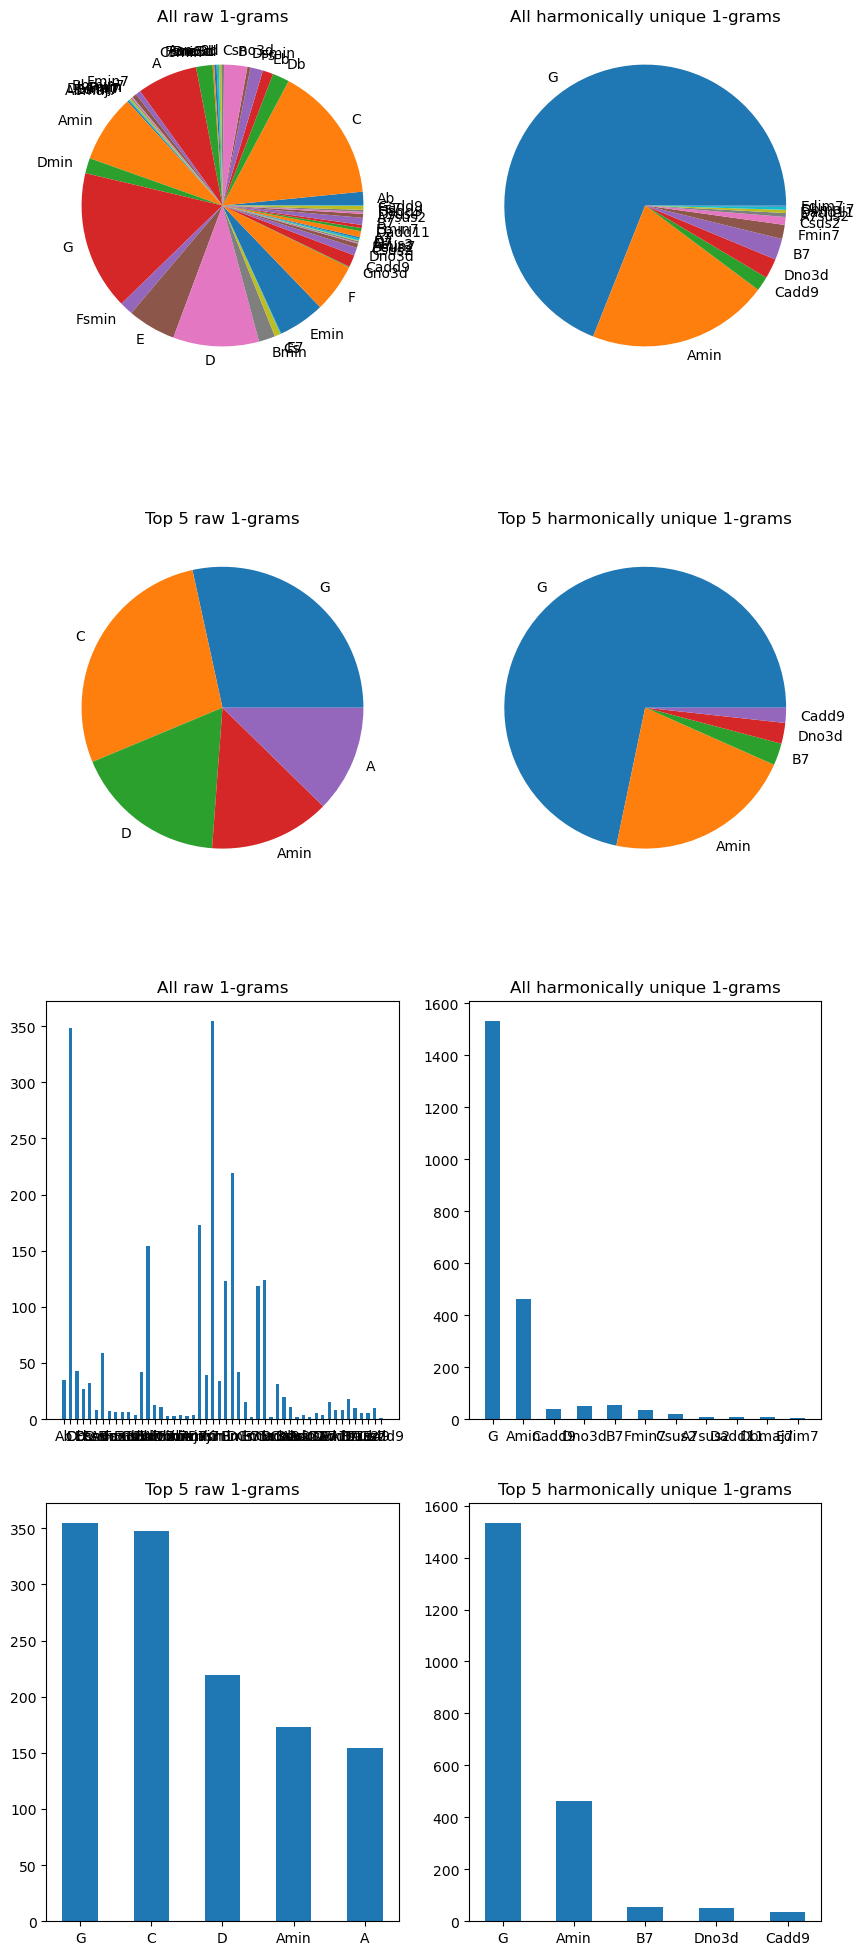

In [17]:
print("Sampled songs:", sample_size)
n = 1
cutoff = 5
raw_n_grams = n_grams(n)
my_unique_n_grams = unique_n_grams(raw_n_grams)
visualize(n = n, 
          n_gram_counter_raw = raw_n_grams,
          n_gram_counter_unique = my_unique_n_grams,
          top_cutoff = cutoff)

Sampled songs: 30
n = 2
Raw number of distinct  2 -grams: 193
Number of harmonically unique  2 -grams: 98
Top 10 most common raw  2 -grams: [('G,C', 119), ('C,G', 108), ('C,Amin', 81), ('D,A', 65), ('F,G', 64), ('F,C', 58), ('G,D', 53), ('Amin,F', 50), ('C,Emin', 47), ('G,Amin', 46)]
Top 10 most common harmonically unique  2 -grams: [('C,G', 367), ('G,C', 258), ('F,G', 173), ('Amin,F', 141), ('E,D', 127), ('C,Amin', 110), ('G,Amin', 98), ('C,Emin', 89), ('Emin,D', 78), ('Amin,C', 67)]


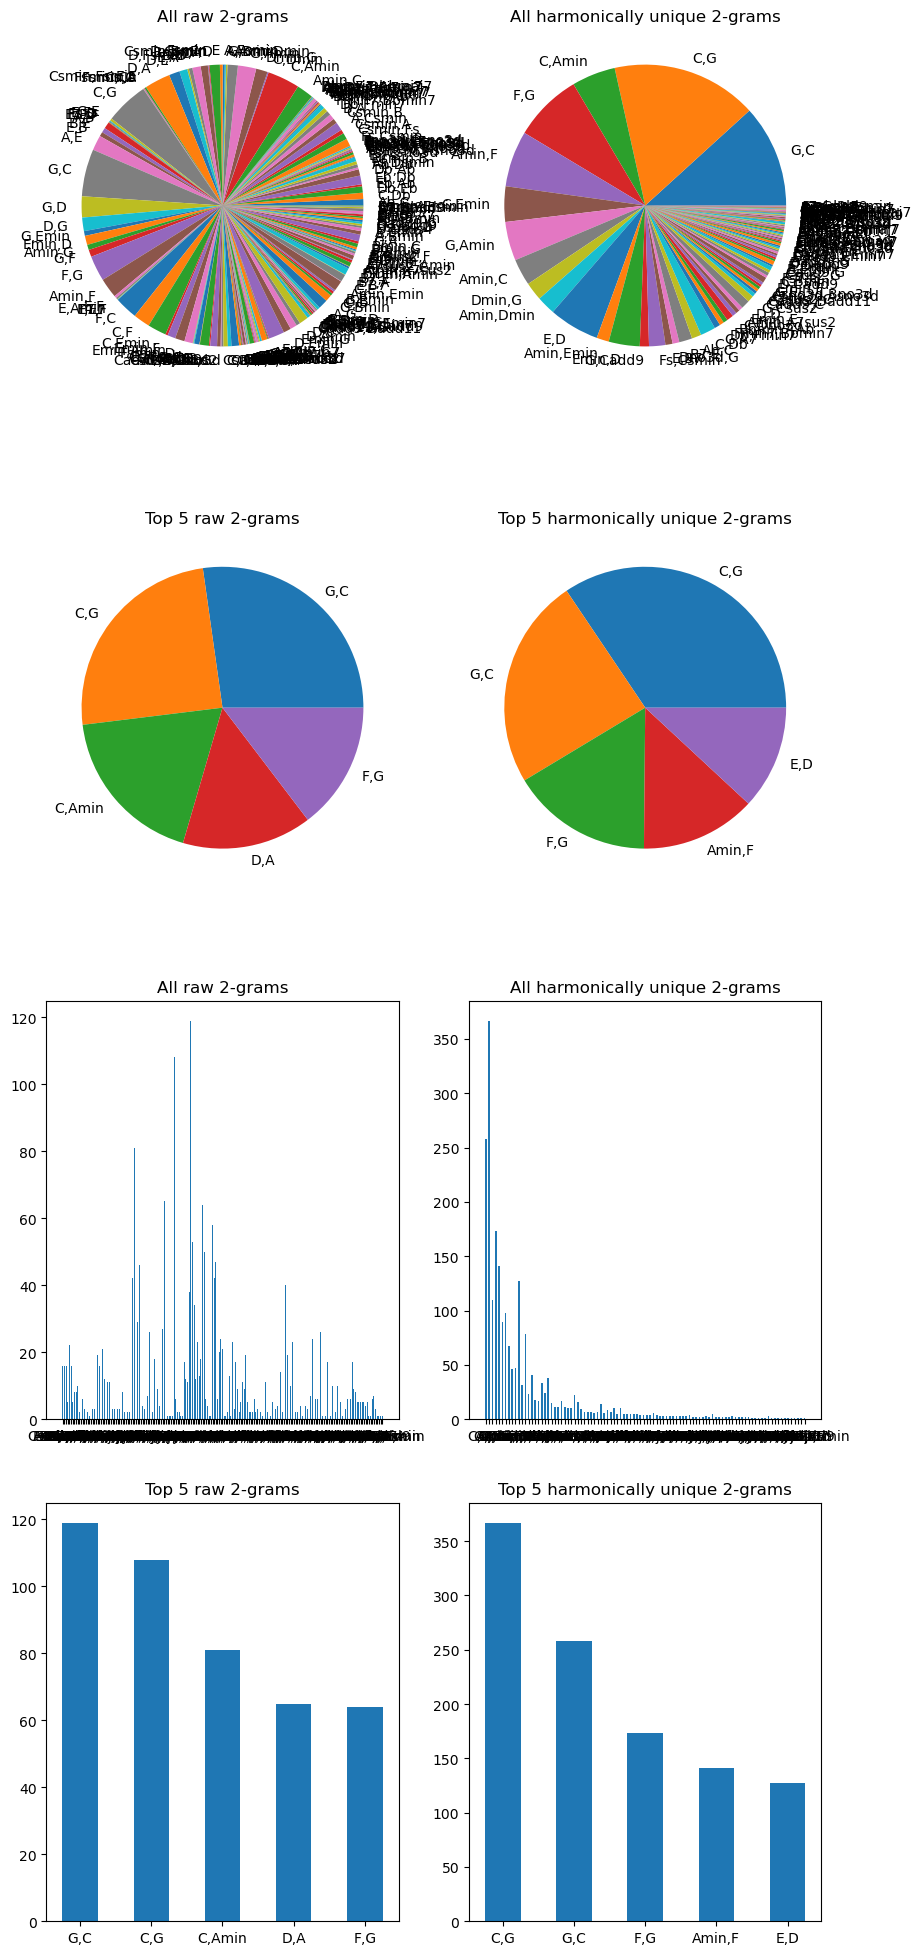

In [18]:
print("Sampled songs:", sample_size)
n = 2
cutoff = 5
raw_n_grams = n_grams(n)
my_unique_n_grams = unique_n_grams(raw_n_grams)
visualize(n = n, 
          n_gram_counter_raw = raw_n_grams,
          n_gram_counter_unique = my_unique_n_grams,
          top_cutoff = cutoff)

Sampled songs: 30
n = 3
Raw number of distinct  3 -grams: 402
Number of harmonically unique  3 -grams: 272
Top 10 most common raw  3 -grams: [('G,C,G', 56), ('F,G,C', 43), ('C,Amin,F', 38), ('C,G,D', 31), ('Amin,C,Amin', 30), ('C,G,C', 30), ('D,A,E', 30), ('G,C,Amin', 28), ('Amin,F,G', 28), ('D,G,C', 27)]
Top 10 most common harmonically unique  3 -grams: [('G,C,G', 106), ('C,G,D', 86), ('C,G,C', 82), ('F,G,C', 74), ('Amin,F,C', 67), ('D,C,G', 57), ('D,G,C', 56), ('G,D,C', 55), ('C,Amin,F', 47), ('A,E,Fsmin', 43)]


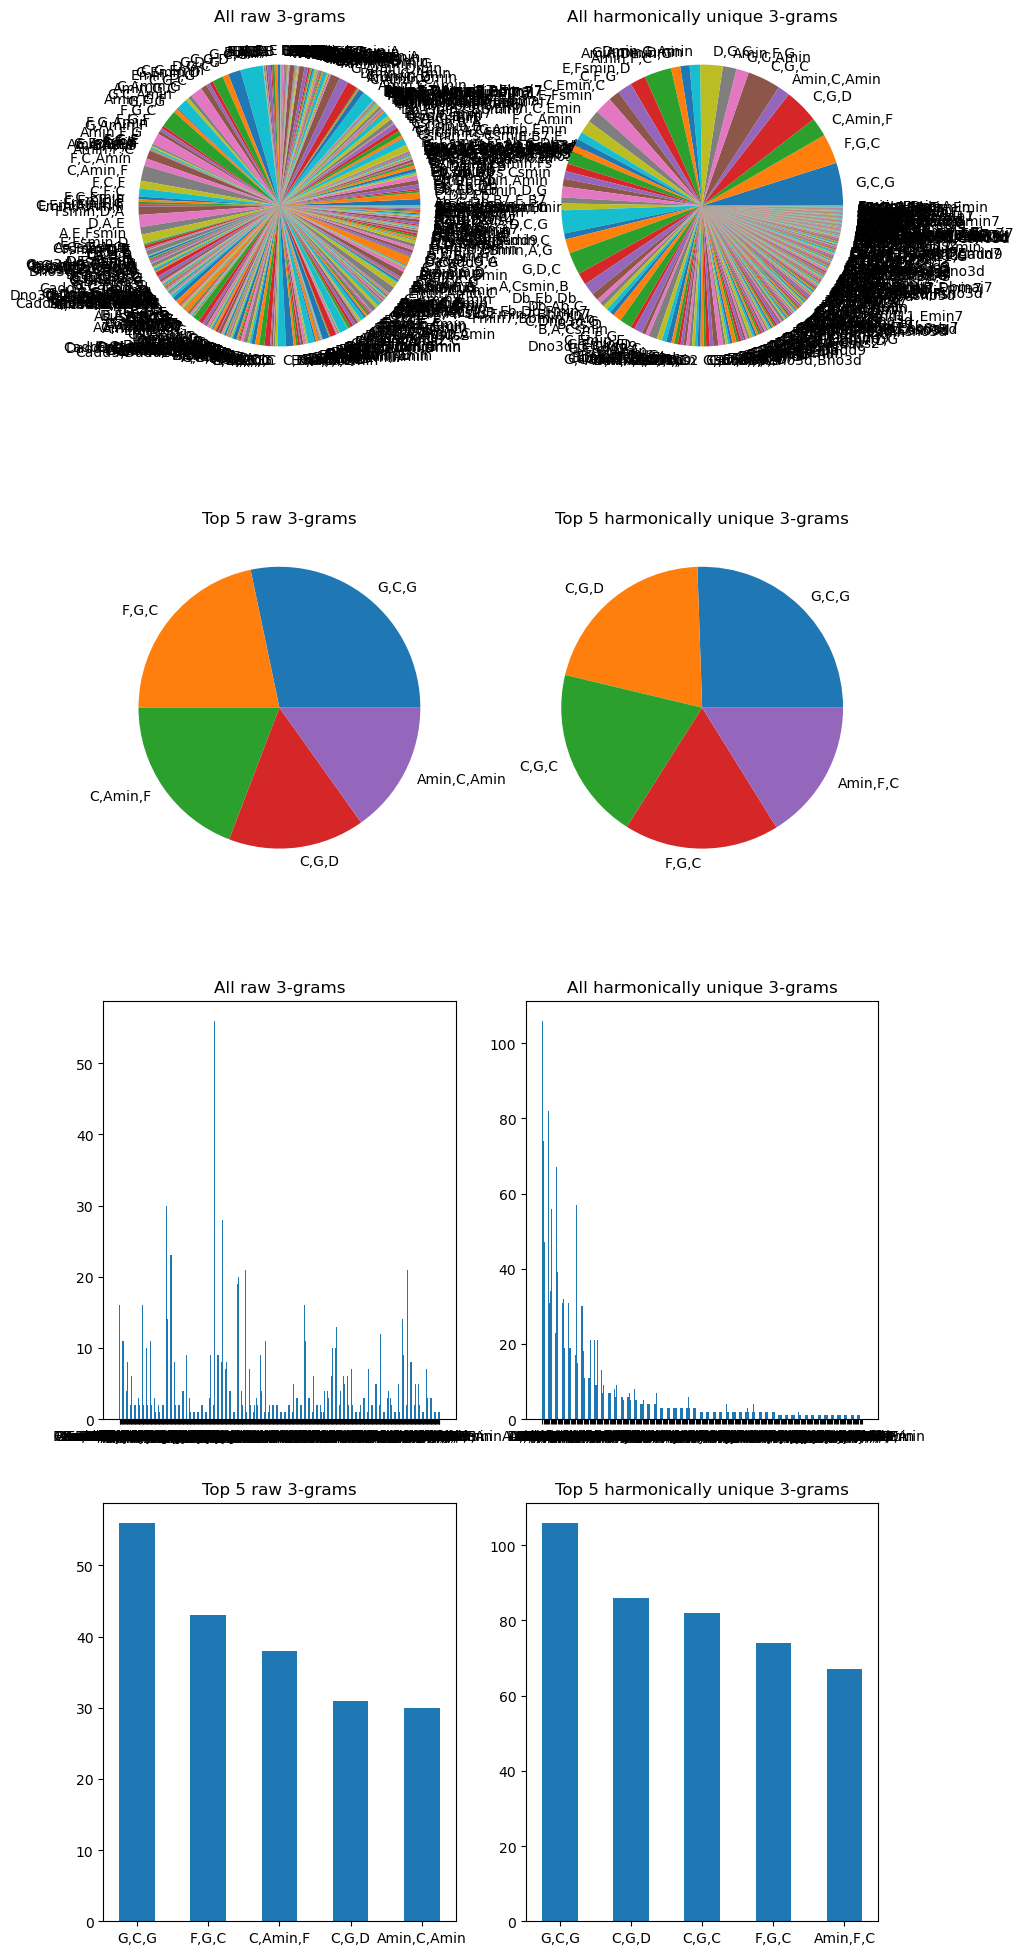

In [19]:
print("Sampled songs:", sample_size)
n = 3
cutoff = 5
raw_n_grams = n_grams(n)
my_unique_n_grams = unique_n_grams(raw_n_grams)
visualize(n = n, 
          n_gram_counter_raw = raw_n_grams,
          n_gram_counter_unique = my_unique_n_grams,
          top_cutoff = cutoff)

Sampled songs: 30
n = 4
Raw number of distinct  4 -grams: 582
Number of harmonically unique  4 -grams: 464
Top 10 most common raw  4 -grams: [('C,G,C,G', 24), ('Dmin,G,Amin,Dmin', 23), ('G,Amin,Dmin,G', 23), ('D,G,C,G', 22), ('F,G,C,Amin', 22), ('Amin,F,G,C', 21), ('C,F,G,C', 21), ('Amin,Dmin,G,Amin', 20), ('F,G,C,F', 20), ('G,C,F,G', 20)]
Top 10 most common harmonically unique  4 -grams: [('C,G,C,G', 59), ('G,C,G,C', 45), ('D,A,E,D', 34), ('G,D,C,G', 33), ('E,D,A,E', 33), ('D,A,E,Fsmin', 31), ('Fsmin,D,A,E', 29), ('C,Amin,F,C', 27), ('C,F,G,C', 26), ('G,C,F,G', 26)]


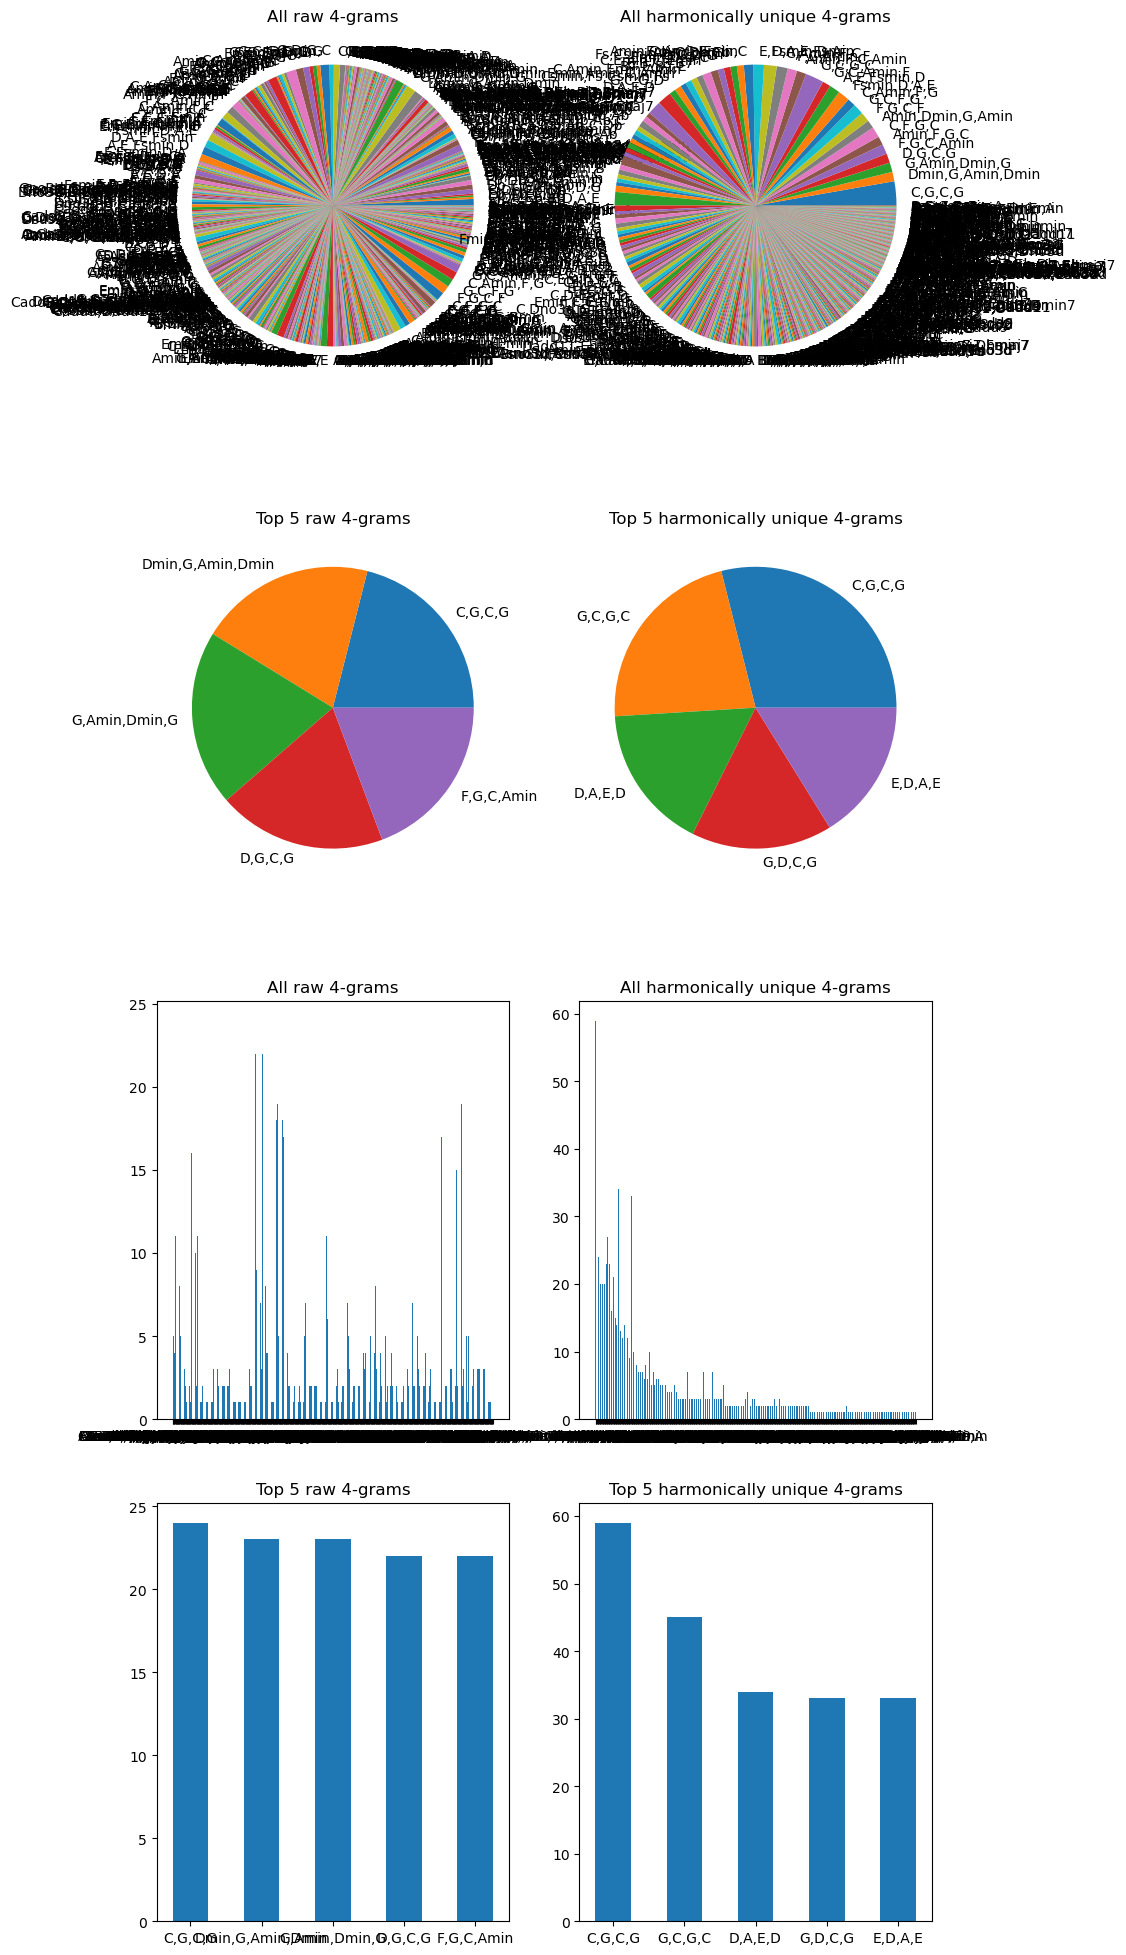

In [20]:
print("Sampled songs:", sample_size)
n = 4
cutoff = 5
raw_n_grams = n_grams(n)
my_unique_n_grams = unique_n_grams(raw_n_grams)
visualize(n = n, 
          n_gram_counter_raw = raw_n_grams,
          n_gram_counter_unique = my_unique_n_grams,
          top_cutoff = cutoff)

In [22]:
# return true/false depending on if a song contains a literal/raw equivalent n_gram to the input n_gram
def contains_raw_n_gram(song, n_gram):
    # assumption: input song is a comma-separated string of chord names
    # assumption: input n_gram is a comma-separated string of chord names
    return (n_gram in song)

assert(contains_raw_n_gram('A,B,C,D,Emin','B,C,D'))

# return true/false depending on if a song contains a harmonically equivalent n_gram to the input n_gram
def contains_n_gram(song, n_gram):
    # assumption: input song is a comma-separated string of chord names
    # assumption: input n_gram is a comma-separated string of chord names
    song_as_matrix = string_to_chord_matrix(song)
    n_gram_as_matrix = string_to_chord_matrix(n_gram)
    song_length = len(song_as_matrix)
    n = len(n_gram_as_matrix)
    for i in range(song_length - n):
        if is_harmonic_equivalent_matrix(n_gram_as_matrix, song_as_matrix[i:i+n]):
            return True
    return False

assert(contains_n_gram('A,B,C,D,Emin','B,C,D'))
assert(contains_n_gram('C,G,C,F,G','C,G,C'))
assert(contains_n_gram('C,G,C,F,G','D,A,D'))
assert(contains_n_gram('C,G,C,F,G','E,B,E'))

Next thing to do: make some kind of visualization of correlating genre with a one-hot column for containing a chord n-gram

In [25]:
# For a given n-gram, make a pie chart of songs that contain the given n-gram
def genre_pie(data, n_gram, column_name):
    # Given an input n-gram (in comma-separated string format),
    # find the songs that contain that n-gram,
    # then make a pie chart of the genres of those songs

    # Step 1: make a deep copy of the data
    df = copy.deepcopy(data)
    
    # Step 2: add a one-hot binary encoded column for containing the n-gram
    df.insert(loc=len(df.columns),
                   column = column_name,
                   value = df['chords'].apply(lambda song : int(contains_n_gram(song, n_gram))))
    
    # Step 3: make a filtered dataframe, containing only songs with the given n-gram
    filtered_df = df[df[column_name] == 1]

    # Step 4: make a pie chart of the genres of the remaining songs
    genre_counter_temp = Counter(filtered_df.genres)
    plt.pie(x = list(genre_counter_temp.values()), 
            labels = list(genre_counter_temp.keys()))
    plt.show()